## Notebook setup & utility helpers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, f1_score, precision_score, recall_score
)

from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rng = 42


## Data Loading

In [2]:
csv_path = "churn.csv"
df = pd.read_csv(csv_path)

In [3]:
df.head()

,Age,AnnualIncome,Gender,MembershipDuration,Location,Churn
0,55,79645.11,Male,4,Urban,0
1,50,42648.21,Male,2,Rural,0
2,54,87496.12,Female,4,Urban,0
3,44,29755.95,Female,6,Urban,0
4,50,97709.25,Male,3,Suburban,0


In [4]:
target = 'Churn' 

X = df.drop(columns=[target])
y = df[target]

## EDA

In [5]:
print("shape:", X.shape)
print("class balance:", pd.Series(y).value_counts(normalize=True).round(3).to_dict())

na_rate = X.isna().mean().sort_values(ascending=False)
print("top missingness:\n", na_rate.head(10))

dup_rate = (df.duplicated().mean())
print("duplicate rows rate:", round(dup_rate, 4))


shape: (200, 5)
class balance: {0: 0.95, 1: 0.05}
top missingness:
 Age                   0.0
AnnualIncome          0.0
Gender                0.0
MembershipDuration    0.0
Location              0.0
dtype: float64
duplicate rows rate: 0.0


## Feature Selection

In [6]:
#applied inside a pipeline later (no leakage)
selector = SelectPercentile(score_func=mutual_info_classif, percentile=40)

## Data Preprocessing

In [7]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

## Data Splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=rng
)

## K-Fold Cross-Validation

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

## Model training fundamentals

In [10]:
logreg = Pipeline([
    ("prep", preprocess),
    ("select", selector),
    ("clf", LogisticRegression(max_iter=400, class_weight="balanced", random_state=rng))
])

tree = Pipeline([
    ("prep", preprocess),
    ("select", selector),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=rng))
])

for name, model in [("logreg", logreg), ("tree", tree)]:
    scores = cross_validate(model, X_train, y_train, cv=cv,
                            scoring=["f1","roc_auc","precision","recall"], n_jobs=-1)
    print(name, {k: round(v.mean(),3) for k,v in scores.items() if k.startswith("test_")})


logreg {'test_f1': 0.66, 'test_roc_auc': 1.0, 'test_precision': 0.5, 'test_recall': 1.0}
tree {'test_f1': 0.827, 'test_roc_auc': 0.897, 'test_precision': 0.933, 'test_recall': 0.8}


## Holdout Evaluation

In [11]:
def eval_holdout(model, X_te, y_te):
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:,1]
    print(classification_report(y_te, y_pred, digits=3))
    print("confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("roc_auc:", round(roc_auc_score(y_te, y_proba), 3))
    print("pr_auc :", round(average_precision_score(y_te, y_proba), 3))

logreg.fit(X_train, y_train);   print("logreg holdout"); eval_holdout(logreg, X_test, y_test)
tree.fit(X_train, y_train);     print("\ntree holdout");  eval_holdout(tree,  X_test, y_test)

logreg holdout
              precision    recall  f1-score   support

           0      1.000     0.974     0.987        38
           1      0.667     1.000     0.800         2

    accuracy                          0.975        40
   macro avg      0.833     0.987     0.893        40
weighted avg      0.983     0.975     0.977        40

confusion matrix:
 [[37  1]
 [ 0  2]]
roc_auc: 1.0
pr_auc : 1.0

tree holdout
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        38
           1      1.000     1.000     1.000         2

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40

confusion matrix:
 [[38  0]
 [ 0  2]]
roc_auc: 1.0
pr_auc : 1.0


## roc & pr plots

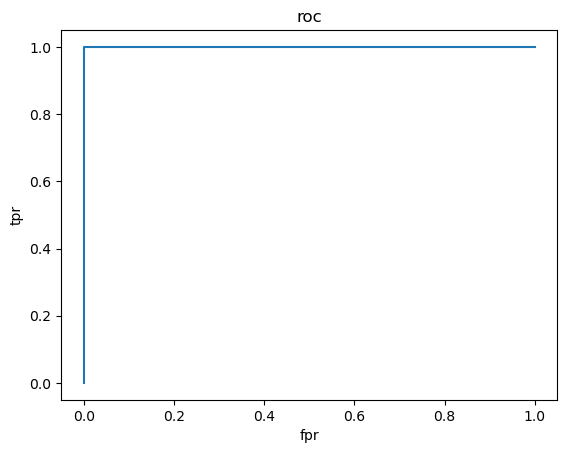

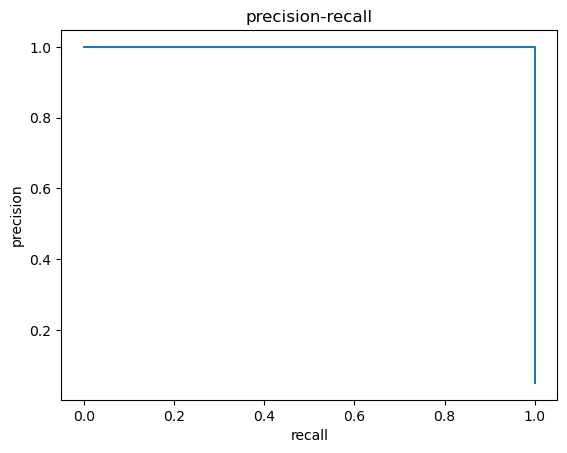

In [12]:
best = logreg  # switch to model you want to display
y_proba = best.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.figure(); plt.plot(fpr, tpr); plt.xlabel("fpr"); plt.ylabel("tpr"); plt.title("roc")
plt.figure(); plt.plot(rec, prec); plt.xlabel("recall"); plt.ylabel("precision"); plt.title("precision-recall")
plt.show()

## Tuning

In [13]:
grid = GridSearchCV(
    Pipeline([("prep", preprocess), ("select", selector),
              ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=rng))]),
    param_grid={"clf__C":[0.1,1.0,3.0,10.0], "clf__solver":["lbfgs","liblinear"]},
    scoring="f1", cv=cv, n_jobs=-1
)
grid.fit(X_train, y_train)
best_logreg = grid.best_estimator_
print("best logreg:", grid.best_params_); print("holdout tuned"); eval_holdout(best_logreg, X_test, y_test)

param_dist = {
    "clf__max_depth": [None] + list(range(2, 21)),
    "clf__min_samples_split": list(range(2, 51, 4)),
    "clf__min_samples_leaf": list(range(1, 31, 4)),
}
rand = RandomizedSearchCV(
    Pipeline([("prep", preprocess), ("select", selector),
              ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=rng))]),
    param_distributions=param_dist, n_iter=40, scoring="f1", cv=cv, n_jobs=-1, random_state=rng
)
rand.fit(X_train, y_train)
best_tree = rand.best_estimator_
print("\nbest tree:", rand.best_params_); print("holdout tuned"); eval_holdout(best_tree, X_test, y_test)

best logreg: {'clf__C': 10.0, 'clf__solver': 'lbfgs'}
holdout tuned
              precision    recall  f1-score   support

           0      1.000     0.974     0.987        38
           1      0.667     1.000     0.800         2

    accuracy                          0.975        40
   macro avg      0.833     0.987     0.893        40
weighted avg      0.983     0.975     0.977        40

confusion matrix:
 [[37  1]
 [ 0  2]]
roc_auc: 1.0
pr_auc : 1.0

best tree: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': 11}
holdout tuned
              precision    recall  f1-score   support

           0      1.000     0.974     0.987        38
           1      0.667     1.000     0.800         2

    accuracy                          0.975        40
   macro avg      0.833     0.987     0.893        40
weighted avg      0.983     0.975     0.977        40

confusion matrix:
 [[37  1]
 [ 0  2]]
roc_auc: 0.993
pr_auc : 0.833


## Ensemble Model

In [14]:
rf = Pipeline([
    ("prep", preprocess),
    ("select", selector),
    ("clf", RandomForestClassifier(
        n_estimators=300, min_samples_split=10, class_weight="balanced",
        n_jobs=-1, random_state=rng
    ))
])

gb = Pipeline([
    ("prep", preprocess),
    ("select", selector),
    ("clf", GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300, max_depth=3, random_state=rng
    ))
])

for name, model in [("rf", rf), ("gb", gb)]:
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=["f1","roc_auc"], n_jobs=-1)
    print(name, {k: round(v.mean(),3) for k,v in scores.items() if k.startswith("test_")})

rf.fit(X_train, y_train); print("\nrf holdout"); eval_holdout(rf, X_test, y_test)
gb.fit(X_train, y_train); print("\ngb holdout"); eval_holdout(gb, X_test, y_test)

rf {'test_f1': 0.75, 'test_roc_auc': 0.964}
gb {'test_f1': 0.333, 'test_roc_auc': 0.92}

rf holdout
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        38
           1      1.000     1.000     1.000         2

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40

confusion matrix:
 [[38  0]
 [ 0  2]]
roc_auc: 1.0
pr_auc : 1.0

gb holdout
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        38
           1      1.000     1.000     1.000         2

    accuracy                          1.000        40
   macro avg      1.000     1.000     1.000        40
weighted avg      1.000     1.000     1.000        40

confusion matrix:
 [[38  0]
 [ 0  2]]
roc_auc: 1.0
pr_auc : 1.0
